<a href="https://colab.research.google.com/github/MereumF/EMBSEEGCOMP/blob/main/Neural_Network_1D_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


In [4]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 req

In [5]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R1", cache_dir=DATA_DIR,
                                  mini=True)


╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=109390;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=979604;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

In [6]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


In [7]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

In [8]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()

In [9]:
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,4278,4478,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,4798,4998,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,5478,5678,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,6318,6518,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,6838,7038,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


In [10]:
import numpy as np
male = 0
female = 0

subject_ids = meta_information["subject"].unique()
print("Subject ID's: ", subject_ids)
print("Ages: ", meta_information["age"].unique())

participants_summary = meta_information[['subject', 'sex']].drop_duplicates()

for i in participants_summary['sex']:
  if i == 'M':
    male +=1
  elif i == 'F':
    female +=1
print("Num of Males: ", male, ". Num of Females: ", female)


Subject ID's:  ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5'
 'NDARCJ594BWQ' 'NDARCN669XPR' 'NDARCW094JCG' 'NDARCZ947WU5'
 'NDARDH670PXH' 'NDARDL511UND' 'NDARDU986RBM' 'NDAREM731BYM'
 'NDAREN519BLJ' 'NDARFK610GY5' 'NDARFT581ZW5' 'NDARFW972KFQ']
Ages:  [11.3386 10.9449 12.8422 13.9757  8.6883  8.3652  6.7472  6.6821 12.4585
  9.6883  8.453   9.3646 13.0092 10.2002  9.926  11.8507  7.0291 10.5204
  6.7034 12.4397]
Num of Males:  12 . Num of Females:  8


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state


subjects = meta_information["subject"].unique()
sub_rm = ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5']
subjects = [s for s in subjects if s not in sub_rm]

train_subj, test_subj = train_test_split(
    subjects, test_size= 0.2 ,random_state=check_random_state(42),shuffle=True)

# sanity check
assert (set(test_subj) | set(train_subj)) == set(subjects)

In [12]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])

    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	1215
Test:	298


In [39]:
window_1 = train_set[15]
#5816 - 5616 = 200 ms --> 2 second window
print("Target of Window #1:", window_1[1])
window_1

Target of Window #1: [1.68]


(array([[ 8.4653084e-06,  6.9837538e-06,  8.5758184e-06, ...,
         -2.2782110e-06,  4.8885527e-06,  9.5120104e-06],
        [ 6.1124933e-06, -2.4088030e-07, -3.9789420e-06, ...,
         -5.5053088e-06,  1.2936817e-06, -1.1614809e-06],
        [ 1.0517597e-05,  5.1259985e-06,  3.1034187e-06, ...,
          3.7373013e-06,  1.0063539e-05,  9.2520795e-06],
        ...,
        [ 2.3057412e-06,  1.9893582e-06,  2.7084332e-06, ...,
         -1.5831420e-05, -3.9213096e-06,  7.7311079e-06],
        [ 5.5845740e-06,  5.4351758e-06,  7.9951215e-06, ...,
         -4.3637374e-06,  7.1913250e-06,  1.9386855e-05],
        [ 5.0000005e-13,  5.0000005e-13,  5.0000005e-13, ...,
          5.0000005e-13,  5.0000005e-13,  5.0000005e-13]], dtype=float32),
 array([1.68]),
 [0, 16336, 16536])

In [45]:
EEG_1, target_1 = train_set[19][:2]  # first element = EEG, second = target
print(EEG_1, target_1)

[[ 2.0016765e-05  2.3812070e-05  2.2369599e-05 ...  2.1007763e-05
   3.2342696e-06  5.9680483e-06]
 [ 1.6498276e-05  2.1771923e-05  2.3530147e-05 ...  1.8142789e-05
  -8.4026742e-06 -4.7694430e-06]
 [ 1.1333552e-05  1.3054925e-05  1.1847851e-05 ...  8.8348861e-06
  -1.4542344e-05 -1.2309818e-05]
 ...
 [ 4.0712137e-05  3.7377660e-05  2.8203536e-05 ...  8.9177292e-06
   1.3918552e-06  2.5619549e-06]
 [ 3.6510963e-05  3.0853767e-05  2.2506803e-05 ...  2.9469270e-06
   8.6279789e-07  6.8348832e-06]
 [ 5.0000005e-13  5.0000005e-13  5.0000005e-13 ...  5.0000005e-13
   5.0000005e-13  5.0000005e-13]] [1.5]


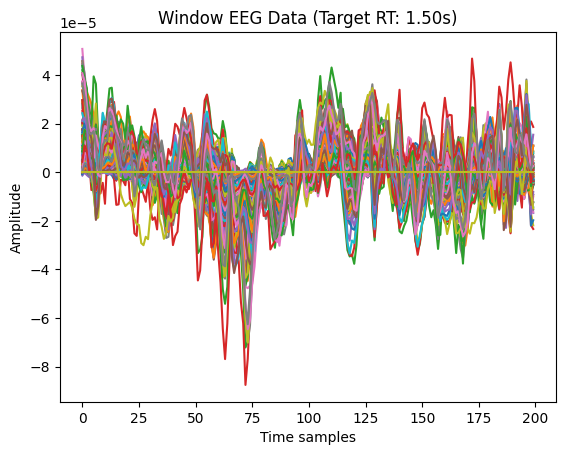

In [46]:
import matplotlib.pyplot as plt
plt.plot(EEG_1.T)  # plot all channels over time
plt.title(f"Window EEG Data (Target RT: {target_1.item():.2f}s)")
plt.xlabel("Time samples")
plt.ylabel("Amplitude")
plt.show()

https://www.geeksforgeeks.org/deep-learning/pytorch-dataloader/

**Batching**: process of grouping data samples into smaller chunks (batches) for efficient training. Enables parallel processing

**Shuffle**: random reordering of data samples for every epoch

**num_workers**: can speed up data loading by allowing multiple samples to be loaded concurrently

In [20]:
# Create dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network/

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

Convolution layer (**CONV**) uses filters that perform convolution operations

Pooling layer (**POOL**) is a downsampling operation, typically applied after a convolution layer, which does some spatial invariance.

Fully connected layer (**FC**) operates on a flattened input where each input is connected to all neurons. If present, FC layers are usually found towards the end of CNN architectures and can be used to optimize objectives such as class scores.


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGRegressor(nn.Module):
    def __init__(self, n_channels=128, n_samples=200, n_meta=1):
        super().__init__()
        # convolution layers
        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=5, padding=2)

        # pooling layer
        self.pool = nn.AdaptiveAvgPool1d(1)

        # fully connected layer
        self.meta_fc = nn.Linear(n_meta, 32)

        # Combined fully connected layers
        self.fc1 = nn.Linear(64 + 32, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        """
        x: (batch_size, n_channels + n_meta, n_samples)
        """
        # Split EEG and metadata
        X_eeg = x[:, :128, :]        # EEG channels
        X_meta = x[:, 128:, 0]       # metadata flattened to (batch, n_meta)

        # EEG CNN path
        x_eeg = F.relu(self.conv1(X_eeg))
        x_eeg = F.relu(self.conv2(x_eeg))
        x_eeg = F.relu(self.conv3(x_eeg))
        x_eeg = self.pool(x_eeg).squeeze(-1)  # (batch, 64)

        # Metadata path
        x_meta = F.relu(self.meta_fc(X_meta))  # (batch, 32)

        # Concatenate EEG + metadata
        x = torch.cat([x_eeg, x_meta], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # predicted RT
        return x

https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html

https://www.datacamp.com/tutorial/adamw-optimizer-in-pytorch

**lr** (**learning rate**): how much to adjust the model weights with respect to the loss gradient during each training step. higher learning rate speeds up training but may cause the model to overshoot optimal weights, while a lower rate allows for more fine-tuned adjustments but can make training slower or get stuck in local minima

**weights_Decay**:  regularization technique used to prevent overfitting by penalizing large weights in the model. adds a small penalty proportional to the size of the model weights during training, helping to reduce model complexity and improve generalization to new data.

**epochs**: one complete pass through the entire training dataset



In [23]:
# Defining training parameters

lr = 1E-3
weight_decay = 1E-5
n_epochs = 100
early_stopping_patience = 50

https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541

Learning rate scheduler:


*    Dynamically adjust the learning rate as training progresses
*   Modifying the learning rate over time based on predefined rules or performance metrics

 **CosineAnnealingLR**: adjust the learning rate following a cosine curve, gradually reducing the rate over each cycle

**StepLR**: decreases the learning rate by a factor at regular intervals

**ReduceLROnPlateau**: reduces the learning rate based on the model's performance on the validation set.




In [24]:
model = EEGRegressor(n_channels=128, n_samples=200).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)
loss_fn = torch.nn.MSELoss()

In [25]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        # Support datasets that may return (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

In [29]:

best_rmse = float("inf")
best_state, best_epoch = None, None
train_rmse_list = []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}/{n_epochs}: ")

    # Train one epoch
    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler=None, epoch=epoch, device=device
    )
    train_rmse_list.append(train_rmse)

    print(f"Train RMSE: {train_rmse:.6f}, Train Loss: {train_loss:.6f}")

    # Optional early stopping on train RMSE
    if train_rmse < best_rmse:
        best_rmse = train_rmse
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model from epoch {best_epoch} with Train RMSE: {best_rmse:.6f}")



Epoch 1/100: 


  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b41e01f4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 1, Batch 10/10, Loss: 0.125816, RMSE: 0.408047: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

Train RMSE: 0.408047, Train Loss: 0.164436

Epoch 2/100: 



  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b41e01f4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 2, Batch 10/10, Loss: 0.132724, RMSE: 0.409371: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

Train RMSE: 0.409371, Train Loss: 0.165814

Epoch 3/100: 



  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b41e01f4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 3, Batch 10/10, Loss: 0.158689, RMSE: 0.407805: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

Train RMSE: 0.407805, Train Loss: 0.165918

Epoch 4/100: 



Epoch 4, Batch 10/10, Loss: 0.229276, RMSE: 0.412250: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

Train RMSE: 0.412250, Train Loss: 0.172962

Epoch 5/100: 



Epoch 5, Batch 10/10, Loss: 0.182945, RMSE: 0.415510: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

Train RMSE: 0.415510, Train Loss: 0.173172

Epoch 6/100: 



Epoch 6, Batch 10/10, Loss: 0.227373, RMSE: 0.418270: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.418270, Train Loss: 0.177612

Epoch 7/100: 



Epoch 7, Batch 10/10, Loss: 0.238265, RMSE: 0.411696: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.411696, Train Loss: 0.172986

Epoch 8/100: 



Epoch 8, Batch 10/10, Loss: 0.167490, RMSE: 0.408469: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

Train RMSE: 0.408469, Train Loss: 0.166880

Epoch 9/100: 



Epoch 9, Batch 10/10, Loss: 0.158714, RMSE: 0.406700: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Train RMSE: 0.406700, Train Loss: 0.165065

Epoch 10/100: 



Epoch 10, Batch 10/10, Loss: 0.163418, RMSE: 0.407989: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Train RMSE: 0.407989, Train Loss: 0.166301

Epoch 11/100: 



Epoch 11, Batch 10/10, Loss: 0.216105, RMSE: 0.405546: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

Train RMSE: 0.405546, Train Loss: 0.167090

Epoch 12/100: 



Epoch 12, Batch 10/10, Loss: 0.188426, RMSE: 0.402894: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

Train RMSE: 0.402894, Train Loss: 0.163649

Epoch 13/100: 



Epoch 13, Batch 10/10, Loss: 0.159067, RMSE: 0.404064: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Train RMSE: 0.404064, Train Loss: 0.163054

Epoch 14/100: 


Epoch 14, Batch 10/10, Loss: 0.142952, RMSE: 0.401928: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.401928, Train Loss: 0.160602

Epoch 15/100: 



Epoch 15, Batch 10/10, Loss: 0.202045, RMSE: 0.405643: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

Train RMSE: 0.405643, Train Loss: 0.166450

Epoch 16/100: 



Epoch 16, Batch 10/10, Loss: 0.179671, RMSE: 0.409600: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

Train RMSE: 0.409600, Train Loss: 0.168376

Epoch 17/100: 



Epoch 17, Batch 10/10, Loss: 0.098665, RMSE: 0.406667: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.406667, Train Loss: 0.161990

Epoch 18/100: 



Epoch 18, Batch 10/10, Loss: 0.140620, RMSE: 0.401415: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

Train RMSE: 0.401415, Train Loss: 0.160093

Epoch 19/100: 



Epoch 19, Batch 10/10, Loss: 0.172641, RMSE: 0.407583: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

Train RMSE: 0.407583, Train Loss: 0.166455

Epoch 20/100: 



Epoch 20, Batch 10/10, Loss: 0.209165, RMSE: 0.403710: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.403710, Train Loss: 0.165327

Epoch 21/100: 



Epoch 21, Batch 10/10, Loss: 0.109497, RMSE: 0.397226: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

Train RMSE: 0.397226, Train Loss: 0.155336

Epoch 22/100: 



Epoch 22, Batch 10/10, Loss: 0.142991, RMSE: 0.400760: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

Train RMSE: 0.400760, Train Loss: 0.159714

Epoch 23/100: 



Epoch 23, Batch 10/10, Loss: 0.194604, RMSE: 0.398576: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.398576, Train Loss: 0.160678

Epoch 24/100: 



Epoch 24, Batch 10/10, Loss: 0.136084, RMSE: 0.399928: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.399928, Train Loss: 0.158731

Epoch 25/100: 



Epoch 25, Batch 10/10, Loss: 0.194705, RMSE: 0.395568: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

Train RMSE: 0.395568, Train Loss: 0.158415

Epoch 26/100: 



Epoch 26, Batch 10/10, Loss: 0.156200, RMSE: 0.395837: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

Train RMSE: 0.395837, Train Loss: 0.156662

Epoch 27/100: 



Epoch 27, Batch 10/10, Loss: 0.137893, RMSE: 0.394388: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.394388, Train Loss: 0.154645

Epoch 28/100: 



Epoch 28, Batch 10/10, Loss: 0.119582, RMSE: 0.391745: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

Train RMSE: 0.391745, Train Loss: 0.151744

Epoch 29/100: 



Epoch 29, Batch 10/10, Loss: 0.110229, RMSE: 0.398228: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Train RMSE: 0.398228, Train Loss: 0.156130

Epoch 30/100: 


Epoch 30, Batch 10/10, Loss: 0.166884, RMSE: 0.391194: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Train RMSE: 0.391194, Train Loss: 0.153736

Epoch 31/100: 


Epoch 31, Batch 10/10, Loss: 0.196124, RMSE: 0.392149: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Train RMSE: 0.392149, Train Loss: 0.155931

Epoch 32/100: 


Epoch 32, Batch 10/10, Loss: 0.074152, RMSE: 0.396166: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

Train RMSE: 0.396166, Train Loss: 0.152743

Epoch 33/100: 



Epoch 33, Batch 10/10, Loss: 0.125606, RMSE: 0.390712: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

Train RMSE: 0.390712, Train Loss: 0.151282

Epoch 34/100: 



Epoch 34, Batch 10/10, Loss: 0.113721, RMSE: 0.389207: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.389207, Train Loss: 0.149564

Epoch 35/100: 



Epoch 35, Batch 10/10, Loss: 0.101706, RMSE: 0.388097: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Train RMSE: 0.388097, Train Loss: 0.148135

Epoch 36/100: 



Epoch 36, Batch 10/10, Loss: 0.163789, RMSE: 0.387081: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

Train RMSE: 0.387081, Train Loss: 0.150541

Epoch 37/100: 



Epoch 37, Batch 10/10, Loss: 0.156618, RMSE: 0.386715: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

Train RMSE: 0.386715, Train Loss: 0.149907

Epoch 38/100: 



Epoch 38, Batch 10/10, Loss: 0.207961, RMSE: 0.389377: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

Train RMSE: 0.389377, Train Loss: 0.154476

Epoch 39/100: 



Epoch 39, Batch 10/10, Loss: 0.197677, RMSE: 0.391488: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

Train RMSE: 0.391488, Train Loss: 0.155518

Epoch 40/100: 



Epoch 40, Batch 10/10, Loss: 0.148593, RMSE: 0.390284: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

Train RMSE: 0.390284, Train Loss: 0.152132

Epoch 41/100: 



Epoch 41, Batch 10/10, Loss: 0.123594, RMSE: 0.399302: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Train RMSE: 0.399302, Train Loss: 0.157622

Epoch 42/100: 



Epoch 42, Batch 10/10, Loss: 0.155280, RMSE: 0.394694: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Train RMSE: 0.394694, Train Loss: 0.155758

Epoch 43/100: 



Epoch 43, Batch 10/10, Loss: 0.183330, RMSE: 0.390365: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

Train RMSE: 0.390365, Train Loss: 0.153957

Epoch 44/100: 



Epoch 44, Batch 10/10, Loss: 0.147071, RMSE: 0.388149: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

Train RMSE: 0.388149, Train Loss: 0.150477

Epoch 45/100: 



Epoch 45, Batch 10/10, Loss: 0.184177, RMSE: 0.382280: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

Train RMSE: 0.382280, Train Loss: 0.148070

Epoch 46/100: 



Epoch 46, Batch 10/10, Loss: 0.204413, RMSE: 0.385388: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

Train RMSE: 0.385388, Train Loss: 0.151362

Epoch 47/100: 



Epoch 47, Batch 10/10, Loss: 0.178160, RMSE: 0.387765: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

Train RMSE: 0.387765, Train Loss: 0.151773

Epoch 48/100: 



Epoch 48, Batch 10/10, Loss: 0.150384, RMSE: 0.382906: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

Train RMSE: 0.382906, Train Loss: 0.146809

Epoch 49/100: 



Epoch 49, Batch 10/10, Loss: 0.126658, RMSE: 0.386754: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

Train RMSE: 0.386754, Train Loss: 0.148415

Epoch 50/100: 



Epoch 50, Batch 10/10, Loss: 0.145323, RMSE: 0.387833: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

Train RMSE: 0.387833, Train Loss: 0.150156

Epoch 51/100: 



Epoch 51, Batch 10/10, Loss: 0.100305, RMSE: 0.382840: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.382840, Train Loss: 0.144217

Epoch 52/100: 



Epoch 52, Batch 10/10, Loss: 0.136037, RMSE: 0.377170: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train RMSE: 0.377170, Train Loss: 0.141942

Epoch 53/100: 


Epoch 53, Batch 10/10, Loss: 0.133250, RMSE: 0.390998: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.390998, Train Loss: 0.151882

Epoch 54/100: 



Epoch 54, Batch 10/10, Loss: 0.172029, RMSE: 0.387688: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

Train RMSE: 0.387688, Train Loss: 0.151405

Epoch 55/100: 



Epoch 55, Batch 10/10, Loss: 0.115297, RMSE: 0.385473: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Train RMSE: 0.385473, Train Loss: 0.146899

Epoch 56/100: 



Epoch 56, Batch 10/10, Loss: 0.127369, RMSE: 0.392105: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

Train RMSE: 0.392105, Train Loss: 0.152407

Epoch 57/100: 



Epoch 57, Batch 10/10, Loss: 0.134487, RMSE: 0.382138: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.382138, Train Loss: 0.145443

Epoch 58/100: 



Epoch 58, Batch 10/10, Loss: 0.133901, RMSE: 0.379528: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

Train RMSE: 0.379528, Train Loss: 0.143526

Epoch 59/100: 



Epoch 59, Batch 10/10, Loss: 0.195251, RMSE: 0.381544: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

Train RMSE: 0.381544, Train Loss: 0.148098

Epoch 60/100: 



Epoch 60, Batch 10/10, Loss: 0.146876, RMSE: 0.380072: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

Train RMSE: 0.380072, Train Loss: 0.144578

Epoch 61/100: 



Epoch 61, Batch 10/10, Loss: 0.129338, RMSE: 0.385253: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

Train RMSE: 0.385253, Train Loss: 0.147451

Epoch 62/100: 



Epoch 62, Batch 10/10, Loss: 0.177041, RMSE: 0.397246: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

Train RMSE: 0.397246, Train Loss: 0.158781

Epoch 63/100: 



Epoch 63, Batch 10/10, Loss: 0.164148, RMSE: 0.383454: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

Train RMSE: 0.383454, Train Loss: 0.147906

Epoch 64/100: 



Epoch 64, Batch 10/10, Loss: 0.093369, RMSE: 0.381770: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

Train RMSE: 0.381770, Train Loss: 0.143088

Epoch 65/100: 



Epoch 65, Batch 10/10, Loss: 0.171692, RMSE: 0.376088: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

Train RMSE: 0.376088, Train Loss: 0.142978

Epoch 66/100: 



Epoch 66, Batch 10/10, Loss: 0.102115, RMSE: 0.373983: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.373983, Train Loss: 0.137947

Epoch 67/100: 



Epoch 67, Batch 10/10, Loss: 0.234447, RMSE: 0.378677: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

Train RMSE: 0.378677, Train Loss: 0.148020

Epoch 68/100: 



Epoch 68, Batch 10/10, Loss: 0.120051, RMSE: 0.372293: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.372293, Train Loss: 0.137660

Epoch 69/100: 



Epoch 69, Batch 10/10, Loss: 0.084708, RMSE: 0.370845: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Train RMSE: 0.370845, Train Loss: 0.134844

Epoch 70/100: 



Epoch 70, Batch 10/10, Loss: 0.157735, RMSE: 0.382009: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train RMSE: 0.382009, Train Loss: 0.146530

Epoch 71/100: 



Epoch 71, Batch 10/10, Loss: 0.119414, RMSE: 0.379473: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.379473, Train Loss: 0.142751

Epoch 72/100: 



Epoch 72, Batch 10/10, Loss: 0.095924, RMSE: 0.367927: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Train RMSE: 0.367927, Train Loss: 0.133367

Epoch 73/100: 



Epoch 73, Batch 10/10, Loss: 0.134901, RMSE: 0.367712: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

Train RMSE: 0.367712, Train Loss: 0.135197

Epoch 74/100: 



Epoch 74, Batch 10/10, Loss: 0.150927, RMSE: 0.377409: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

Train RMSE: 0.377409, Train Loss: 0.142869

Epoch 75/100: 



Epoch 75, Batch 10/10, Loss: 0.154438, RMSE: 0.376612: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

Train RMSE: 0.376612, Train Loss: 0.142477

Epoch 76/100: 



Epoch 76, Batch 10/10, Loss: 0.173402, RMSE: 0.378999: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Train RMSE: 0.378999, Train Loss: 0.145151

Epoch 77/100: 



Epoch 77, Batch 10/10, Loss: 0.226675, RMSE: 0.379808: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.379808, Train Loss: 0.148439

Epoch 78/100: 



Epoch 78, Batch 10/10, Loss: 0.141525, RMSE: 0.376407: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.376407, Train Loss: 0.141674

Epoch 79/100: 



Epoch 79, Batch 10/10, Loss: 0.115867, RMSE: 0.372098: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

Train RMSE: 0.372098, Train Loss: 0.137310

Epoch 80/100: 



Epoch 80, Batch 10/10, Loss: 0.111154, RMSE: 0.387158: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

Train RMSE: 0.387158, Train Loss: 0.147924

Epoch 81/100: 



Epoch 81, Batch 10/10, Loss: 0.091145, RMSE: 0.376067: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

Train RMSE: 0.376067, Train Loss: 0.138873

Epoch 82/100: 



Epoch 82, Batch 10/10, Loss: 0.174657, RMSE: 0.363519: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

Train RMSE: 0.363519, Train Loss: 0.134305

Epoch 83/100: 



Epoch 83, Batch 10/10, Loss: 0.186036, RMSE: 0.365546: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

Train RMSE: 0.365546, Train Loss: 0.136285

Epoch 84/100: 



Epoch 84, Batch 10/10, Loss: 0.117590, RMSE: 0.363028: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

Train RMSE: 0.363028, Train Loss: 0.131068

Epoch 85/100: 



Epoch 85, Batch 10/10, Loss: 0.127723, RMSE: 0.367106: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

Train RMSE: 0.367106, Train Loss: 0.134409

Epoch 86/100: 



Epoch 86, Batch 10/10, Loss: 0.132235, RMSE: 0.364045: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

Train RMSE: 0.364045, Train Loss: 0.132514

Epoch 87/100: 



Epoch 87, Batch 10/10, Loss: 0.201158, RMSE: 0.377010: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

Train RMSE: 0.377010, Train Loss: 0.145134

Epoch 88/100: 



Epoch 88, Batch 10/10, Loss: 0.120715, RMSE: 0.379489: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

Train RMSE: 0.379489, Train Loss: 0.142829

Epoch 89/100: 



Epoch 89, Batch 10/10, Loss: 0.154231, RMSE: 0.365981: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

Train RMSE: 0.365981, Train Loss: 0.134973

Epoch 90/100: 



Epoch 90, Batch 10/10, Loss: 0.093852, RMSE: 0.360625: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

Train RMSE: 0.360625, Train Loss: 0.128212

Epoch 91/100: 



Epoch 91, Batch 10/10, Loss: 0.116769, RMSE: 0.364114: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

Train RMSE: 0.364114, Train Loss: 0.131776

Epoch 92/100: 



Epoch 92, Batch 10/10, Loss: 0.182161, RMSE: 0.363247: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

Train RMSE: 0.363247, Train Loss: 0.134498

Epoch 93/100: 



Epoch 93, Batch 10/10, Loss: 0.131566, RMSE: 0.369784: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

Train RMSE: 0.369784, Train Loss: 0.136478

Epoch 94/100: 



Epoch 94, Batch 10/10, Loss: 0.228938, RMSE: 0.377434: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

Train RMSE: 0.377434, Train Loss: 0.146848

Epoch 95/100: 



Epoch 95, Batch 10/10, Loss: 0.136896, RMSE: 0.376852: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

Train RMSE: 0.376852, Train Loss: 0.141757

Epoch 96/100: 



Epoch 96, Batch 10/10, Loss: 0.152116, RMSE: 0.374169: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

Train RMSE: 0.374169, Train Loss: 0.140617

Epoch 97/100: 



Epoch 97, Batch 10/10, Loss: 0.143027, RMSE: 0.363642: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Train RMSE: 0.363642, Train Loss: 0.132784

Epoch 98/100: 



Epoch 98, Batch 10/10, Loss: 0.144163, RMSE: 0.362710: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

Train RMSE: 0.362710, Train Loss: 0.132198

Epoch 99/100: 



Epoch 99, Batch 10/10, Loss: 0.134857, RMSE: 0.359641: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

Train RMSE: 0.359641, Train Loss: 0.129622

Epoch 100/100: 



Epoch 100, Batch 10/10, Loss: 0.130902, RMSE: 0.366885: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Train RMSE: 0.366885, Train Loss: 0.134417
Loaded best model from epoch 99 with Train RMSE: 0.359641


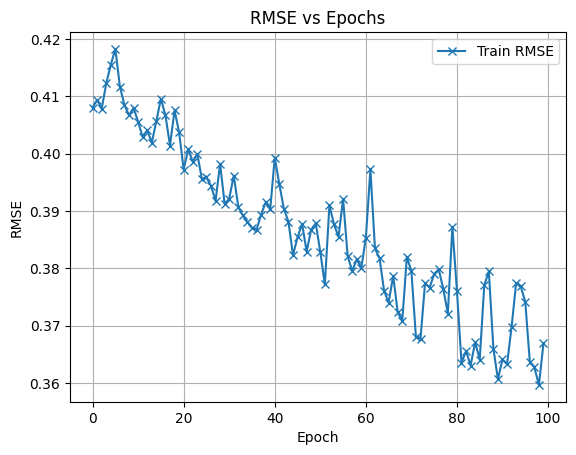

In [30]:
plt.plot(train_rmse_list, label="Train RMSE", marker='x')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
model.load_state_dict(best_state)
model.eval()


EEGRegressor(
  (conv1): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): AdaptiveAvgPool1d(output_size=1)
  (meta_fc): Linear(in_features=1, out_features=32, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)